In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pandas as pd

In [18]:
header = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

In [19]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [20]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [21]:
n_split = 20000
ratings_train = ratings[n_split:]
ratings_val = ratings[:n_split]
len(ratings_train), len(ratings_val)

(80000, 20000)

In [23]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1682 943 1650


In [24]:
# Por el embedding que arranca en 1
ratings_train['userId'].min(), ratings_train['movieId'].min()

(1, 1)

In [25]:
from keras.layers import Embedding, Input, Flatten, Dot
from keras import Model
from keras.constraints import non_neg

Using TensorFlow backend.


In [26]:
n_latent_factors = 3

In [27]:
movie_input = Input(shape=[1], name='Item')
# movie_embedding = Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_embedding = Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
#user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 
#                                                  n_latent_factors,name='User-Embedding', embeddings_constraint=non_neg())(user_input))

In [28]:
prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [29]:
from keras.optimizers import Adam

In [30]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [31]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [32]:
model.compile(Adam(lr=0.001), 'mean_squared_error', metrics=[root_mean_squared_error])

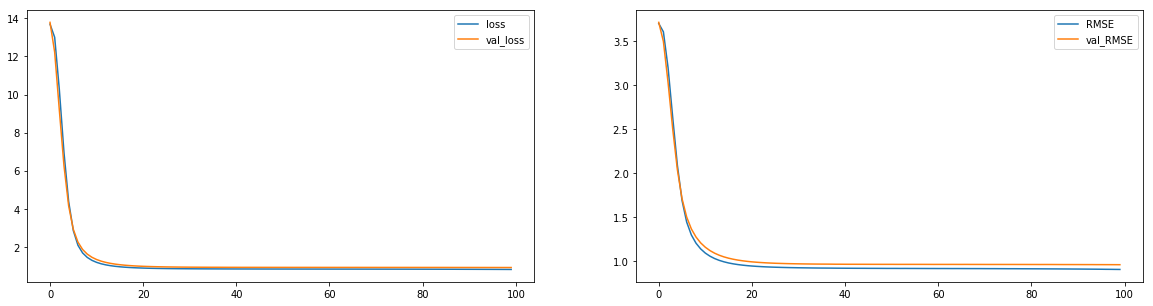

In [33]:
history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    batch_size=320,
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    epochs=100, 
                    callbacks = [plot_losses],
                    verbose=1)

In [34]:
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

20000/20000 [==============================] - 0s 12us/step


[0.9192151617527008, 0.9497253823280335]